# Markov-Decision-Process

## Terms Definition

1. **Markov Decision Process** -

1. **State-Value Function** - The state-value function, $v_\pi(s)$, of a MDP is the expected
return starting from state $s$ and then following policy $\pi$. The mathematical definition is
$v_\pi(s) = \mathbb{E}_{\pi}[G_t | S_t = s]$. In other words, state-value function tells us
how good is it to be in state $s$ and following policy $\pi$.

1. **Action-Value Function** - The action-value function $q_\pi(s,a)$ is the expected return
starting from state $s$, taking action $a$ and then following policy $\pi$. The mathematical definition
is $q_\pi(s) = \mathbb{E}_{\pi}[G_t | S_t = s, A_t = a]$. Action-value function tells us how good is it to
take a particular action from a particular state. Gives us an idea on what action we should take at states.

1. **Reward Function** - A reward function is a function which represent the reward the agent gets. The reward
can be influence by the state ($s$), action ($a$) and next state ($s'$). The most common forms of reward functions are:
    - $r(s): S \rightarrow \mathbb{R} $ - reward for being in state $s$.
    - $r(s,a): S \times A \rightarrow \mathbb{R} $ - reward for being in state $s$ and applying action a.
    - $r(s,a, s'): S \times A \times S \rightarrow \mathbb{R} $ - reward for being in state $s$, applying action $a$ and
    move to state $s'$.

1. **Policy** - A policy $\pi$ mapping from states to actions. There are two types
of policies - deterministic policy ($\pi(s_t) = a_t$) and stochastic policy ($\pi(a|s) = p(A_t = a | S_t = s, \pi)$).
The deterministic policy map for each state a specific action, and the stochastic
policy map for each state probability for each action. The optimal policy $\pi*$ maximize the expected total future rewards.

1. **Bellman Equations** -

1. **Dynamic Programming** -

1. **Value Iteration** -

1. **Policy Iteration** -

1. **Reinforcement Learning** -

## MDP Gridworld

First thing - import libraries.

In [45]:
%matplotlib inline
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import pickle
from MDP.World import World
from MDP.mdp import TransitionModel, RewardFunction, MDP

### Transition Model & Reward Function

For constructing the transition model I was needed to compute
4 different matrices, one for each action. For each action I computed the probability
for moving from $s$ state to $s'$ state using the action. Then I construct this as a matrix where
the rows represent the 'from' state and the columns represent the 'to'. For example the probability
in cell $(3,4)$ represent the probability to move from state $3$ to state $4$ using the action.

*Note*: I treated the obstacle as extended state, i.e., the state is not reachable at all.
Hence, it not part of the transition model and reward function.

The matrices can be seen in the appendix, but I still load them here.

In [46]:
actions = ['north', 'east', 'south', 'west']
path = 'transition_model/{}.pkl'
tm_matrices = [pickle.load(open(path.format(a), 'rb')) for a in actions]

Now to make it easier for use I created a class names `TransitionModel` which wrap all the above-mentioned
matrices. The constructor of the class gets list of actions and list of probability matrices (as pandas DataFrames).
Then I implemented the method `prob` which computes the probability $p(s'|s,a)$. For example:

In [47]:
transition_model = TransitionModel(actions = [a[0] for a in actions],
                                   transition_matrices=tm_matrices)

print('P(s` = 1 | s = 5, a = N) = {}'.format(transition_model.prob(1, 5, 0)))

P(s` = 1 | s = 5, a = N) = 0.1


Now for the reward function.
In each transition from $s$ to $s'$ the robots get reward of $-0.04$. In transition
to the goal state or to a hole the robot gets **in addition** a reward of
$+1$ or $-1$ corresponded. I construct a reward function for each action, where
$r(s, a, s')$ will be great than zero only if it possible to move from $s$ to $s'$ using
$a$. The matrices can be found in the appendix.

In [48]:
path = 'reward_function/{}.pkl'
reward_matrices = [pickle.load(open(path.format(a), 'rb')) for a in actions]

I implemented a class names `RewardFunction` which represent a reward function. The constructor
gets a list of actions and list of reward matrix for each action. Then I implements a method
to get easily the reward $r(s, a, s')$ by using the method `reward()` which get ($s, a, s'$) and returns
the corresponded reward. For the avoidance of doubt here too I will print out all the matrices I got:


In [49]:
reward_function = RewardFunction(actions = [a[0] for a in actions],
                                 reward_matrices=reward_matrices)

print('r(s = 2, a = N, s` = 1) = {}'.format(reward_function.reward(2, 0, 1)))

r(s = 2, a = N, s` = 1) = -1.04


And now for the graphical model when action is 'North':

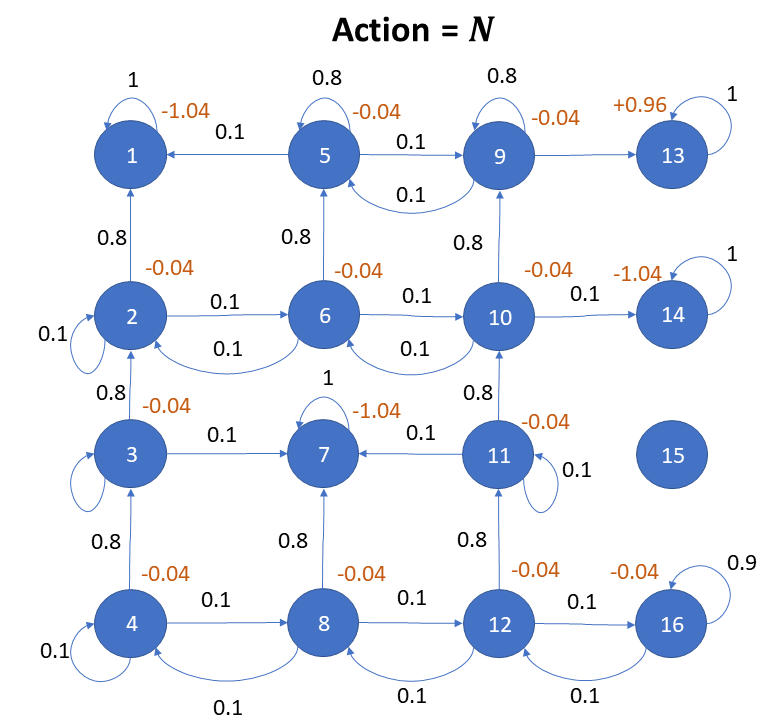

In [50]:
display(Image.open('images/MDP_north.png'))


### Value Iteration (I)

In order to solve the MDP using value iteration algorithm I implemented a method called `value_iteration`
which get as input a threshold input $\theta$ and returns a policy $\pi$.
I used $\theta = 10^{-4}$ as threshold and $\gamma = 0.99$ as discount factor.

Now let's create a MDP instance and solve it while using the value iteration algorithm.

Solving MDP using value iteration algorithm...
Convergence after 14 iterations


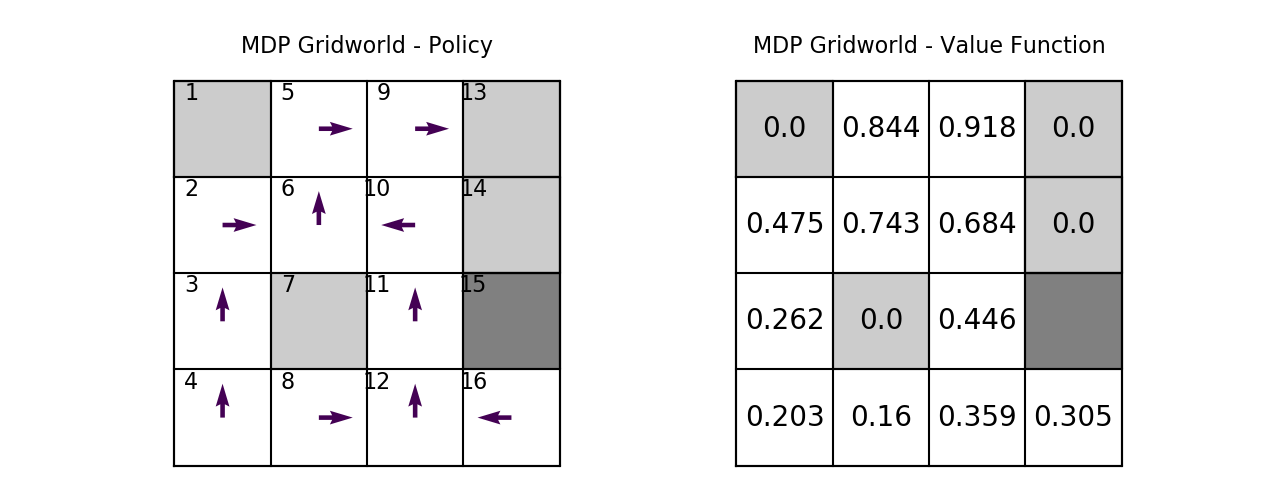

In [51]:
# Create a MDP instance
mdp = MDP(World(), transition_model, reward_function, gamma=0.99)

# Solve it using value iteration algorithm
mdp.value_iteration(theta=10 ** -4, verbose=True)
display(Image.open('images/section_b.png'))

So that seem like a great policy!

The only thing I was wondered about was the 0.0 at each terminal state.
I believe it because in the reward function I used $r(1, a, 1) = 0$ for example.
I assume it is correct because the definition we got for a $v(s)$ is: "the expected
return starting from state $s$", so if I start in a terminal state, I will
stay there and will have 0 cookies (I understand the problem as getting a cookie for entering
a terminal state, but if I already inside I will get nothing).

### Value Iteration (II)

Next I repeated the value iteration algorithm but now with $\gamma = 0.9$.
The gamma is a reflection of how you value your future reward. For example,
choosing $gamma = 0$ would means that you are going for a greedy policy
where the long-term future does not matter at all.

Solving MDP using value iteration algorithm...
Convergence after 10 iterations


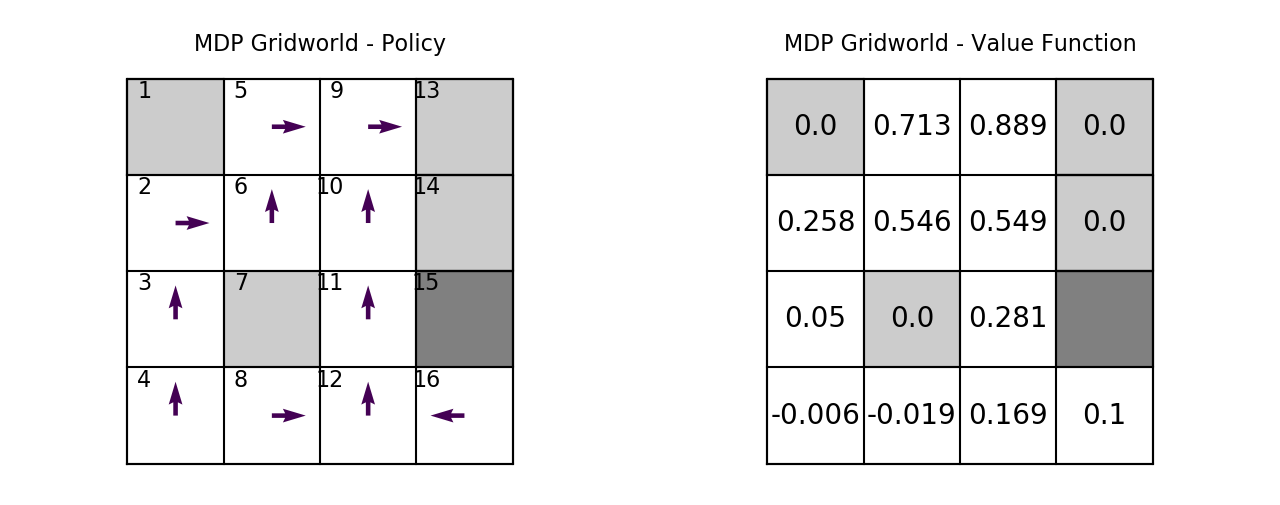

In [52]:
# Set new MDP object but now with gamma = 0.9
mdp = MDP(World(), transition_model, reward_function, gamma=0.9)

# Solve & Plot
mdp.value_iteration(theta=10 ** -4)
display(Image.open('images/section_c.png'))

First, about the value function, we can notice that the values are smaller than before.
This make sense because the equation we use for the optimal value function is $\mathcal{R}_s^a + \gamma \sum{p(s'|s,a)V(s')}$.
The expression $\mathcal{R}_s^a$ doesn't depend on gamma, so small gamma will make the right expression to be smaller.
Conceptually, smaller gamma will value less the future rewards, that's why the value
function of each state became smaller when using smaller gamma (in our problem conditions).

Over the policy, we can see the only change is:
$$\pi_{\gamma=0.99}(s_{10}) = W; \quad \pi_{\gamma=0.9}(s_{10}) = N$$

I think it because the fact that using smaller gamma will make the policy to be more greedy.
The second policy, i.e. $\gamma = 0.9$, see more cookies when going north, so it make this move despite
we can fall into the hole in the right. The first policy, i.e. $\gamma=0.99$, more "afraid" from future holes,
and hence decides to go west and avoid any future holes.

### Value Iteration (III)

Now we need to repeat the value iteration algorithm but with $\gamma = 0.9$ and $r = -0.02$.
I added to the `RewardFunction` class a staticmethod which gets a reward matrix, current
transition's reward and new transition reward and returns the reward matrix
with the new transition's reward. I used it to update the constructed reward matrices to fit
the section's demands. Then I used these matrices for the MDP:

Solving MDP using value iteration algorithm...
Convergence after 10 iterations


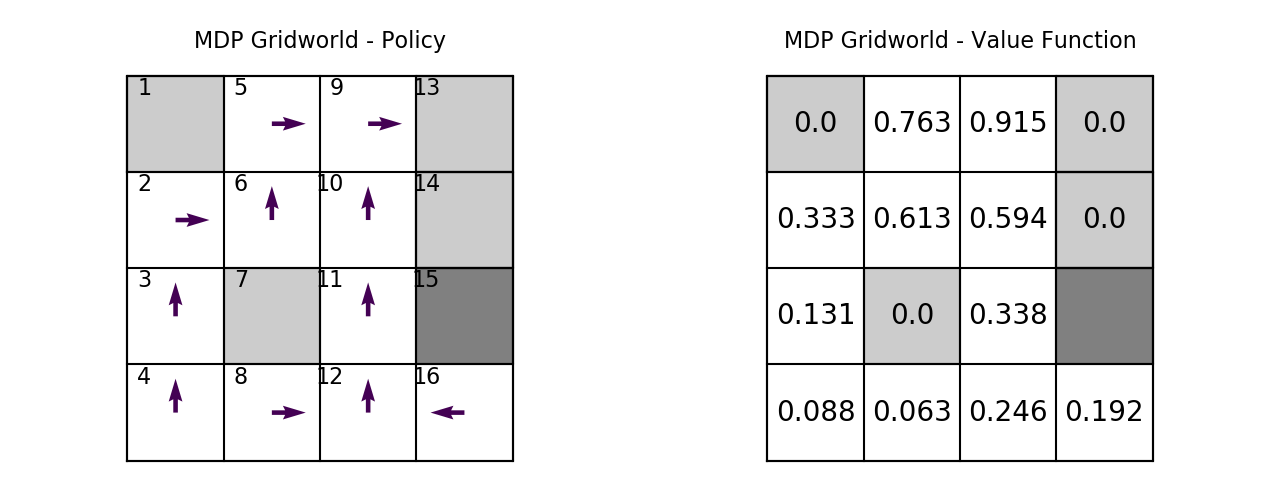

In [53]:
# Create the new reward function (r = -0.02)
new_reward_matrices = [RewardFunction.change_transition_reward(m, -0.04, -0.02)
                       for m in reward_matrices]
new_reward_function = RewardFunction(actions=[a[0] for a in actions],
                                     reward_matrices=new_reward_matrices)

# Solve & Plot
mdp = MDP(World(), transition_model, new_reward_function, gamma=0.9)
mdp.value_iteration(theta=10 ** -4)
display(Image.open('images/section_d.png'))


About the value function - we can notice that all values became larger compared
to section c. It make sense because we increased $r$ (paying less for each transition)
so larger values were expected.

About the policy - it stay the same as section c. It look like increasing
$r$ to -0.02 wasn't enough for the greedy policy to make a round in order to avoid
a possible fall to the hole in state 14.


### Policy Iteration


# Appendix

## Transition Model

In [54]:
for i in range(len(actions)):

    print('\nAction = {}\n{}'.format(actions[i], tm_matrices[i]))


Action = north
     1    2    3    4    5    6    7    8    9    10   11   12   13   14   16
1   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.8  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.8  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4   0.0  0.0  0.8  0.1  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.1  0.0  0.0  0.0  0.8  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0
6   0.0  0.1  0.0  0.0  0.8  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.1  0.0  0.0  0.8  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.8  0.0  0.0  0.0  0.1  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.8  0.0  0.0  0.0  0.0  0.1  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.8  0.1  0.0  0.0  0.0  0.0
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0 

## Reward Function

In [55]:
for i in range(len(actions)):

    print('\nAction = {}\n{}'.format(actions[i], reward_matrices[i]))


Action = north
      1     2     3     4     5     6     7     8     9     10    11    12  \
1   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2  -1.04 -0.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00  0.00  0.00  0.00   
3   0.00 -0.04 -0.04  0.00  0.00  0.00 -1.04  0.00  0.00  0.00  0.00  0.00   
4   0.00  0.00 -0.04 -0.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00  0.00   
5  -1.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00   
6   0.00 -0.04  0.00  0.00 -0.04  0.00  0.00  0.00  0.00 -0.04  0.00  0.00   
7   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
8   0.00  0.00  0.00 -0.04  0.00  0.00 -1.04  0.00  0.00  0.00  0.00 -0.04   
9   0.00  0.00  0.00  0.00 -0.04  0.00  0.00  0.00 -0.04  0.00  0.00  0.00   
10  0.00  0.00  0.00  0.00  0.00 -0.04  0.00  0.00 -0.04  0.00  0.00  0.00   
11  0.00  0.00  0.00  0.00  0.00  0.00 -1.04  0.00  0.00 -0.04 -0.04  0.00   
12  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.